### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

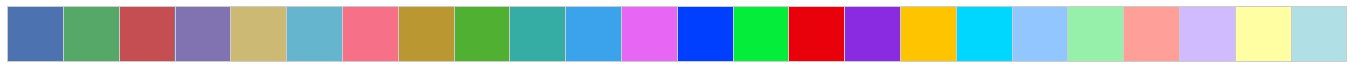

In [111]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
import warnings
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform
from transformers.cosine import add_coses, to_degrees
from transformers.momentum import add_is_muon, add_is_muon_tight, add_probability_hit_detector
from transformers.err import add_mse, add_normed_err, err_cols, add_errs, create_distr, get_dll_pdf, get_dll_cdf, ez

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [52]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + foi_cols
global_feature_importance = None
train, train_foi = read_train(used_cols, 1000000)
display(train.shape, count_classes(train))

(1000000, 63)

(421218, 578782)

Wall time: 5.02 s


In [97]:
%%time
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
global_foi_train_data = pd.read_pickle(closest_hits_filename).loc[:, xyz_cols + t_cols + dxyz_cols].copy()
global_foi_train_data.columns = cl_cols
print(global_foi_train_data.columns)

Index(['Cl_MatchedHit_X[0]', 'Cl_MatchedHit_X[1]', 'Cl_MatchedHit_X[2]',
       'Cl_MatchedHit_X[3]', 'Cl_MatchedHit_Y[0]', 'Cl_MatchedHit_Y[1]',
       'Cl_MatchedHit_Y[2]', 'Cl_MatchedHit_Y[3]', 'Cl_MatchedHit_Z[0]',
       'Cl_MatchedHit_Z[1]', 'Cl_MatchedHit_Z[2]', 'Cl_MatchedHit_Z[3]',
       'Cl_MatchedHit_T[0]', 'Cl_MatchedHit_T[1]', 'Cl_MatchedHit_T[2]',
       'Cl_MatchedHit_T[3]', 'Cl_MatchedHit_DX[0]', 'Cl_MatchedHit_DX[1]',
       'Cl_MatchedHit_DX[2]', 'Cl_MatchedHit_DX[3]', 'Cl_MatchedHit_DY[0]',
       'Cl_MatchedHit_DY[1]', 'Cl_MatchedHit_DY[2]', 'Cl_MatchedHit_DY[3]',
       'Cl_MatchedHit_DZ[0]', 'Cl_MatchedHit_DZ[1]', 'Cl_MatchedHit_DZ[2]',
       'Cl_MatchedHit_DZ[3]'],
      dtype='object')
Wall time: 2.94 s


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

In [53]:
# готовим данные для распределения DLL

# либо загружаем уже готовое
closest_hits_filename = 'data/train_closest_hits_replaced.pkl'
# dll_train = pd.read_pickle(closest_hits_filename)
# display(dll_train.columns)

# либо считаем заново
dll_train, _ = read_train(xy_cols + dx_cols + dy_cols + exy_cols, 10000000)
dll_train = add_mse(dll_train, [])

# опционально пересчитываем MatchedHits и заменяем ими координаты треков в dll_train, чтобы считать распределение на пересчитанных треках
# dll_train = replace_hits(dll_train, [])

# save DLL
# display(dll_train.columns)
# dll_train.to_pickle(closest_hits_filename)

In [54]:
# если распределение для DLL уже есть сохраненное, то загружаем
# cdfs, pdfs, bins = np.load('data/train_cdfs.pkl.npy'), np.load('data/train_pdfs.pkl.npy'), np.load('data/train_bins.pkl.npy')

# либо считаем на основе загруженного dll_train
cdfs, pdfs, bins = create_distr(dll_train)
# np.save('data/train_cdfs.pkl.npy', cdfs)
# np.save('data/train_pdfs.pkl.npy', pdfs)
# np.save('data/train_bins.pkl.npy', bins)

In [124]:
a = np.array([[1., 2.], [4., 5]])
b = 3.

np.hstack((a, np.tile(b, a.shape[0]).reshape((-1, 1))))

array([[1., 2., 3.],
       [4., 5., 3.]])

In [185]:
a = np.arange(2, 14). reshape((4, 3))
a * np.array([1., 1., 0.])
# b = a * 4
# # np.division()

# # a / 
# # b = b[:, np.newaxis]
# a / b

array([[ 2.,  3.,  0.],
       [ 5.,  6.,  0.],
       [ 8.,  9.,  0.],
       [11., 12.,  0.]])

In [220]:
vm_cols = ['V', 'VT', 'M', 'MT']

def add_velocity(data, features):
    def get_layer_coords(data, cols, i):
        return data[[cols[i], cols[i+4], cols[i+8]]].values
    def get_elayer_coords(data, i):
        exy = data.loc[:, [ex_cols[i], ey_cols[i]]].values
        ez_ = np.tile(ez[i], exy.shape[0]).reshape((-1, 1))
        return np.hstack((exy, ez_))
    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    def norm(x):
        return np.sqrt(dot(x, x))
    def get_zero_point(data):
        layers = [get_elayer_coords(data, i) for i in range(2)]
        r = layers[1] - layers[0]
        r = r / norm(r)[:, np.newaxis]
        p = get_elayer_coords(data, 0)
        alpha = - p[:, 2] / r[:, 2]
        
        xs = p[:, 0] + alpha * r[:, 0]
        ys = p[:, 1] + alpha * r[:, 1]
        zs = np.tile(0, len(xs))
        return np.vstack((xs, ys, zs)).T
    
    # radius-vector r_i = p_i - p_0: S x N x 3; 
    r = np.array([get_layer_coords(data, xyz_cols, i) for i in range(4)]) - get_zero_point(data)
    
    # time: S x N
    t = data.loc[:, t_cols].values.T
    
    # average velocity avg(r / t): N x 3    
    v_avg = np.nanmean(r / t[:, :, np.newaxis], axis=0)
    # average speed |v|: N
    speed = norm(v_avg)
    # transverse speed |v_xy|: N
    speed_tr = norm(v_avg * np.array([1., 1., 0.]))
    
    # momentum: N
    p = data.loc[:, mom_cols[0]].values
    # transverse momentum: N
    p_tr = data.loc[:, mom_cols[1]].values
    
    # mass: N
    m = p / speed
    # transverse mass: N
    m_tr = p_tr / speed_tr

#     print('===========')
#     return data
    
#     s = np.array(list(map(norm, r)))
#     avg_v = np.nanmean(s / t, axis=0)
#     print(avg_v.shape)
    
#     avg_v_vec = np.nanmean(r / t[:, :, np.newaxis], axis=0)
#     print(avg_v_vec.shape)
    
#     tt = np.nanmean(r / t[:, :, np.newaxis], axis=0)
#     tt /= norm(tt)[:, np.newaxis]
#     avg_v_vec /= norm(avg_v_vec)[:, np.newaxis]
#     print(tt.shape)
#     print(np.std(avg_v_vec - tt))
    
#     rvs = rs / vs
    
    data.loc[:, vm_cols[0]] = speed
    data.loc[:, vm_cols[1]] = speed_tr
    data.loc[:, vm_cols[2]] =  / avg_vel
    features += vm_cols
    return data    
    
df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=1000, transformer_cls=DataTransformer)
display(df_scores.describe())
# dt = add_velocity(train.copy(), [])
# dt.loc[:, 'V'].plot()
# dt.loc[:, t_cols[0]].hist()

# i = 2
# plt.hist(np.nan_to_num(np.clip(dt.loc[:, z_cols[i]].values / dt.loc[:, t_cols[i]].values, 0, 1e+10)))

(4, 666, 3) (4, 666) (666, 3)
(666,)
(4, 334, 3) (4, 334) (334, 3)
(334,)
(4, 666, 3) (4, 666) (666, 3)
(666,)
(4, 334, 3) (4, 334) (334, 3)
(334,)
(4, 668, 3) (4, 668) (668, 3)
(668,)
(4, 332, 3) (4, 332) (332, 3)
(332,)


,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.738986,0.726742,0.884719,0.797620,0.745709,0.618279,0.127907
std,0.016170,0.023145,0.020575,0.007964,0.021610,0.171813,0.026953
min,0.727545,0.711382,0.865979,0.789838,0.732732,0.426677,0.103438
25%,0.729736,0.713432,0.873711,0.793552,0.733235,0.548094,0.113462
50%,0.731928,0.715481,0.881443,0.797267,0.733738,0.669511,0.123485
75%,0.744706,0.734422,0.894090,0.801511,0.752197,0.714080,0.140142
max,0.757485,0.753363,0.906736,0.805755,0.770655,0.758649,0.156798


In [5]:
def add_dll(data, features):
    data[err_cols[1]] = get_dll_pdf(data.loc[:, err_cols[0]], pdfs, cdfs, bins)
    features += err_cols[1:2]
    return data

In [108]:
def fit(train, n_estimators, transformer_cls):
    labels, weights = get_labels_weights(train.loc[:, train_cols])

    # defined much later
    transformer = transformer_cls().fit(train)
    train_values = transformer.transform(train)
    
    estimator = xgb.XGBClassifier(n_estimators=n_estimators, n_jobs=3)
    estimator.fit(train_values, labels, eval_metric=scoring.rejection90_sklearn, sample_weight=weights)
    return transformer, estimator


In [48]:
# здесь пока хуй пойми что :)

hc_preimage_cols = xyz_cols + t_cols + dxyz_cols
hc_image_cols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
seg_col = foi_ts_cols[2]
nrows = 10
train, train_foi = read_train(used_cols, nrows)

# по идее должен заполнять датафрейм ближайшими хитами
def fill_global_closest_matched_hits(data, data_foi):
#     data_foi.astype({seg_col: np.int8}, copy=False)
    cur_foi_cols = foi_xyz_cols[:2] + foi_dxyz_cols[:2] + foi_ts_cols[:1] + foi_ts_cols[-1:]
    data_foi = data_foi.loc[:, ['id'] + cur_foi_cols]
    data_foi.set_index('id', inplace=True)
    
    segs = [data_foi.loc[data_foi[seg_col] == i, :] for i in range(4)]
    display(segs[2])
    
#     data_foi.set_index(['id', seg_col], inplace=True)
    
#     join = data_foi.join(data.loc[:, exy_cols], how='right')
#     s0 = join.loc[(slice(None), 0), :]
#     s0 = s0.set_index(s0.index.droplevel(1))
#     s1 = join.loc[(slice(None), 1), :]
#     s1 = s1.set_index(s1.index.droplevel(1))
#     display(s0.join(s1, how='outer', lsuffix='_0', rsuffix='_1'))
#     display(s0.set_index(['id']).join(s1.set_index(['id']), how='inner', lsuffix='_0', rsuffix='_1'))
#     for i in range(4):
#         join.loc[(slice(None), i), :]
#         slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
#         dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
#         dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
#         join.loc[mask, 'D2'] = dx**2 + dy**2
        
#     res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
#     res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
#     subcols = hc_image_cols
#     nsubcols = len(subcols)
#     for i, col in enumerate(cl_cols):
#         mask = res[foi_ts_cols[2]] == (i % 4)
#         indices = res.loc[mask, 'id']
#         data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

global_foi_train_data = fill_global_closest_matched_hits(train, train_foi)
# df_scores, feature_importance = cross_validate(train, n_estimators=20, n_splits=3, n_rows=nrows, transformer_cls=DataTransformer)
# display(df_scores.describe())

,FOI_hits_X,FOI_hits_Y,FOI_hits_DX,FOI_hits_DY,FOI_hits_T,FOI_hits_S
id,,,,,,
0,-3376.969971,1590.397461,118.0,146.278412,7.0,2.0
0,-3140.969971,1590.397461,118.0,146.278412,7.0,2.0
1,827.000000,2764.196533,118.0,146.278412,8.0,2.0
2,-1933.969971,-221.993256,59.0,73.078896,3.0,2.0
3,-1933.969971,-221.993256,59.0,73.078896,8.0,2.0
4,-1815.969971,1089.198242,59.0,73.078896,5.0,2.0


In [178]:
%%time
from sklearn.base import TransformerMixin

def filter_unimportant_features(features):
    if global_feature_importance is None:
        return features
    fscore = global_feature_importance
    return [col for col in features if col not in fscore.index or fscore.loc[col, 'score'] > 0.01]
    return features

def replace_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col[3:]] = global_foi_data.loc[data.index.values, col].values
    return data

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
        return self

    def transform(self, data):
        data = data.copy()
        features = [] + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols + hit_stats_cols + t_cols + ncl_cols + avg_cs_cols + xyz_cols
        features = filter_unimportant_features(features)
        self.origin_features = features.copy()

#         data = replace_hits(data, features)
        add_coses(data, features)
        add_mse(data, features)
        add_normed_err(data, features)
        add_dll(data, features)
        add_errs(data, features)
        add_velocity(data, features)
#         add_cl_hits(data, features)
#         add_cl_mse(data, features)
        
#         filter_data(data)
        if not features:
            raise('no features')
    
        features = filter_unimportant_features(features)
        self.new_features = features[len(self.origin_features):]
        self.features = self.origin_features + self.new_features
        return data[features].values

df_scores, feature_importance = cross_validate(train, n_estimators=60, n_splits=3, n_rows=10000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
mean,0.777800,0.769570,0.880283,0.821210,0.806907,0.668832,0.108702
std,0.003780,0.003070,0.003729,0.003037,0.007003,0.068107,0.004136
min,0.773777,0.766034,0.877847,0.818138,0.801459,0.610358,0.104935
25%,0.776061,0.768576,0.878137,0.819710,0.802957,0.631442,0.106489
50%,0.778344,0.771117,0.878427,0.821282,0.804456,0.652525,0.108042
75%,0.779811,0.771337,0.881501,0.822746,0.809630,0.698069,0.110585
max,0.781278,0.771558,0.884576,0.824210,0.814805,0.743613,0.113128


Wall time: 2.11 s


### Test theory

In [179]:
%%time
global_feature_importance = None
df_scores, feature_importance = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())
# display(feature_importance)

,acc,prec,rec,f1,roc_auc,scr,th
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.789960,0.782605,0.880806,0.828804,0.822877,0.745064,0.083946
std,0.004313,0.004411,0.002082,0.003179,0.004825,0.027542,0.001957
min,0.784361,0.776199,0.877599,0.824938,0.816793,0.708831,0.081259
25%,0.786900,0.780508,0.880208,0.826211,0.818576,0.732522,0.082527
50%,0.790440,0.783091,0.880977,0.829155,0.825531,0.743622,0.084772
75%,0.794050,0.786525,0.882450,0.831830,0.826152,0.757906,0.085480
max,0.794050,0.786702,0.882796,0.831884,0.827331,0.782442,0.085693


Wall time: 1min 51s


In [180]:
global_feature_importance = feature_importance.copy()
sum(global_feature_importance.score > .01)

24

In [181]:
display(global_feature_importance)

,score
ErrMSE,0.127381
PT,0.102381
NShared,0.052381
M,0.041667
DAngle[2],0.039286
DAngle[1],0.038095
ncl[2],0.034524
P,0.029762
NErr_X[3],0.028571
NErr_Y[3],0.027381


### Get result

In [109]:
test, test_foi = read_pub_test(used_cols)
global_foi_test_data = fill_global_closest_matched_hits(test.copy(), test_foi)

In [110]:
%%time
global_feature_importance = None
fit_predict_save(sample(train, 100000), test, "out/09_naive_v_m_w_cl.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 55.9 s


In [107]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_120.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6min 57s


In [108]:
%%time
fit_predict_save(sample(train, 1000000), test, "out/09_plus_all_orig_features_1000_200.csv", n_estimators=200, transformer_cls=DataTransformer)

Wall time: 11min 39s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


### Scratches

In [139]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [5]:
from transformers.cosine import da_cols
from transformers.err import err_cols, nerr_xy_cols

In [99]:
def to_closest_cols(cols):
    return ['Cl_' + col for col in cols]

cl_xyz_cols = to_closest_cols(xyz_cols)
cl_t_cols = to_closest_cols(t_cols)
cl_dxyz_cols = to_closest_cols(dxyz_cols)
cl_cols = cl_xyz_cols + cl_t_cols + cl_dxyz_cols

def fill_global_closest_matched_hits(data, data_foi):
    data.loc[:, 'id'] = data.index.values
    exy = data.loc[:, exy_cols]
    data_foi = data_foi.astype({foi_ts_cols[2]: np.int16})
    join = data_foi.join(exy, on='id', how='inner')
    for i in range(4):
        mask = join[foi_ts_cols[2]] == i
        slc = join.loc[mask, ['id', foi_ts_cols[2], exy_cols[i], exy_cols[i+4], foi_xyz_cols[0], foi_xyz_cols[1]]]
        dx = slc.loc[:, exy_cols[i]].values - slc.loc[:, foi_xyz_cols[0]].values
        dy = slc.loc[:, exy_cols[i+4]].values - slc.loc[:, foi_xyz_cols[1]].values
        join.loc[mask, 'D2'] = dx**2 + dy**2
        
    res = join.sort_values(by=['id', foi_ts_cols[2], 'D2'])
    res = res.drop_duplicates(subset=['id', foi_ts_cols[2]])
        
    subcols = foi_xyz_cols + foi_ts_cols[:1] + foi_dxyz_cols
    nsubcols = len(subcols)
    for i, col in enumerate(cl_cols):
        mask = res[foi_ts_cols[2]] == (i % 4)
        indices = res.loc[mask, 'id']
        data.loc[indices, col] = res.loc[mask, subcols[i // 4]].values
    return data

def add_cl_hits(data, features):
    global_foi_data = global_foi_train_data if train_cols[0] in data.columns else global_foi_test_data
    for col in cl_cols:
        data.loc[:, col] = global_foi_data.loc[data.index.values, col].values        
    features += cl_cols
    return data

def add_cl_mse(data, features):
    dxy = (data.loc[:, cl_xyz_cols[:8]].values - data.loc[:, exy_cols].values) / data.loc[:, cl_dxyz_cols[:8]].values / 2.
    D = np.nanmean(dxy**2, axis=1)
    
    col = 'cl_' + err_cols[0]
    data.loc[:, col] = D
    features += [col]
    return data

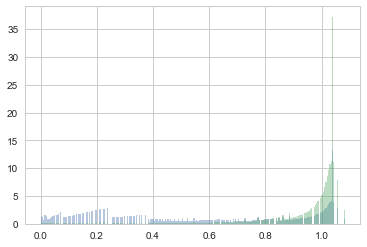

In [133]:
def plot_dll(data):
    DLL = get_dll_cdf(data, pdfs, cdfs, bins)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        _ = sns.distplot(DLL, bins=len(bins), kde=False, norm_hist=True)

dts = [dt.loc[:, err_cols[0]] for dt in split_classes(dll_train)]
plot_dll(dts[0].values)
plot_dll(dts[1].values)
# plot_dll(dll_train.loc[:, err_cols[0]].values)